# Company Churn Prediction
Creating a simple Randomforest Classifier from records about companies, industry, revenue, # of employee... using SageMaker SDK

In [9]:
import numpy as np
import pandas as pd
import boto3
import re, os
import sagemaker
from pandas.api.types import CategoricalDtype

In [10]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = boto3.Session().region_name
data_bucket = sess.default_bucket()

In [11]:
PREFIX = "company-churn"
data_file = "companies.csv"


## Build the training and validation data sets

Be sure to have the companies.csv file on local folder, or run the simulator to create data

In [12]:
datafile_path=os.path.join("./", data_file)
df = pd.read_csv(datafile_path)
df.info()
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company        10000 non-null  object
 1   Industry       10000 non-null  object
 2   Revenue        10000 non-null  int64 
 3   Employees      10000 non-null  int64 
 4   #job30         10000 non-null  int64 
 5   #job90         10000 non-null  int64 
 6   MonthlyCharge  10000 non-null  int64 
 7   TotalCharge    10000 non-null  int64 
 8   Churn          10000 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 703.2+ KB


col_0,% observations
Company,
comp_0,0.0001
comp_1,0.0001
comp_10,0.0001
comp_100,0.0001
comp_1000,0.0001
...,...
comp_9995,0.0001
comp_9996,0.0001
comp_9997,0.0001


col_0,% observations
Industry,
IT,0.1032
consulting,0.1109
energy,0.1135
finance,0.1159
gov,0.1137
health,0.1101
retail,0.1100
service,0.1120
travel,0.1107


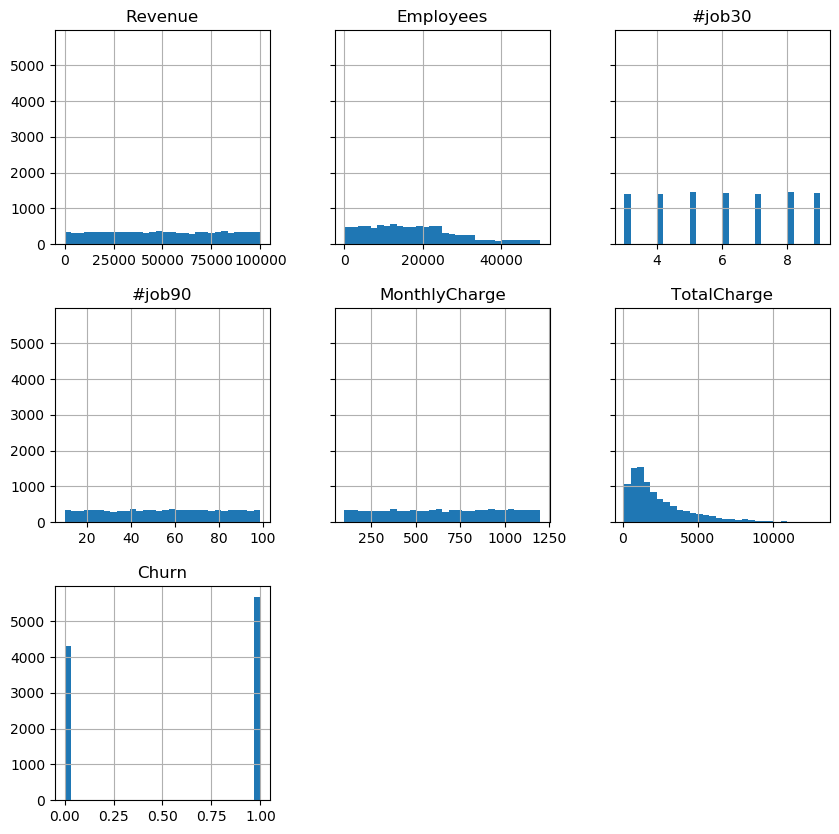

In [13]:
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

In [14]:
industryCat = df["Industry"].unique()
industry_type = CategoricalDtype(categories=industryCat)
df = df.drop(['Company'],axis=1)
df = pd.get_dummies(df,columns=['Industry'])

In [18]:
train_data, test_data, _ = np.split(df.sample(frac=1, random_state=1729), [int(0.8 * len(df)), len(df)])
train_data.to_csv('train.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [20]:
boto3.Session().resource('s3').Bucket(data_bucket).Object(os.path.join(PREFIX, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(data_bucket).Object(os.path.join(PREFIX, 'validation/test.csv')).upload_file('test.csv')


In [22]:
# creating the inputs for the fit() function with the training and validation location
s3_train_data = f"s3://{data_bucket}/{PREFIX}/train"
print(f"training files will be taken from: {s3_train_data}")

s3_validation_data = f"s3://{data_bucket}/{PREFIX}/validation"
print(f"validtion files will be taken from: {s3_validation_data}")

s3_test_data = f"s3://{data_bucket}/{PREFIX}/test"
print(f"test files will be taken from: {s3_test_data}")

output_location = f"s3://{data_bucket}/{PREFIX}/output"
print(f"training artifacts output location: {output_location}")

# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

training files will be taken from: s3://sagemaker-us-west-2-403993201276/company-churn/train
validtion files will be taken from: s3://sagemaker-us-west-2-403993201276/company-churn/validation
test files will be taken from: s3://sagemaker-us-west-2-403993201276/company-churn/test
training artifacts output location: s3://sagemaker-us-west-2-403993201276/company-churn/output


In [23]:
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", boto3.Session().region_name, version="1")
print(container)

174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:1


In [24]:
from time import gmtime, strftime
job_name = "Linear-learner-company-churn-" + strftime("%H-%M-%S", gmtime())
print("Training job", job_name)

linear = sagemaker.estimator.Estimator(
    container,
    role,
    input_mode="File",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)

linear.set_hyperparameters(
    epochs=16,
    wd=0.01,
    loss="absolute_loss",
    predictor_type="regressor",
    normalize_data=True,
    optimizer="adam",
    mini_batch_size=1000,
    lr_scheduler_step=100,
    lr_scheduler_factor=0.99,
    lr_scheduler_minimum_lr=0.0001,
    learning_rate=0.1,
)
linear.fit(inputs={"train": train_data, "validation": validation_data}, job_name=job_name)

Training job Linear-learner-company-churn-22-40-03
2022-12-20 22:40:03 Starting - Starting the training job...ProfilerReport-1671576003: InProgress
...
2022-12-20 22:40:47 Starting - Preparing the instances for training............
2022-12-20 22:42:48 Downloading - Downloading input data......
2022-12-20 22:43:58 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/20/2022 22:44:01 INFO 140076536690496] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0

In [25]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.c4.xlarge")
print(f"\ncreated endpoint: {linear_predictor.endpoint_name}")

-------!
created endpoint: linear-learner-2022-12-20-22-46-34-258


In [ ]:
# Try some prediction

In [26]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

In [28]:
test_data


,Revenue,Employees,#job30,#job90,MonthlyCharge,TotalCharge,Churn,Industry_IT,Industry_consulting,Industry_energy,Industry_finance,Industry_gov,Industry_health,Industry_retail,Industry_service,Industry_travel
5046,71120,17780,5,46,305,2649,1,1,0,0,0,0,0,0,0,0
3148,30190,7548,9,18,1000,7157,1,0,1,0,0,0,0,0,0,0
934,53110,26555,4,99,831,5334,1,0,0,0,1,0,0,0,0,0
8677,69060,34530,6,21,157,679,0,0,0,0,0,1,0,0,0,0
6879,48020,16007,6,47,937,3291,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6029,24900,12450,5,58,1103,3101,1,1,0,0,0,0,0,0,0,0
5669,7410,3705,4,86,795,3814,1,0,1,0,0,0,0,0,0,0
1267,97950,32650,9,81,952,9339,0,0,0,0,0,0,0,0,1,0
3174,6710,3355,8,97,116,370,0,0,0,0,0,1,0,0,0,0


TypeError: 'TrainingInput' object is not subscriptable